In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def load_data(filename:str):
    return pd.read_csv(filename+".csv")
concrete = load_data("V7")

In [ ]:
concrete.head()

**Unnamed** - номера строк, сразу же удалим их

In [ ]:
concrete = concrete.drop("Unnamed: 0",axis=1)
y_column_name = "concrete_compressive_strength"
y_column_number = 4

concrete.info()

Можно заметить, что в категории **fly_ash** встречаются **NotaNumber** значения

In [ ]:
concrete.describe()

In [ ]:
concrete.hist(bins=200,figsize=(20,15))
plt.show()

Это просто **ЖОПА**, а не данные. ~~я просто ибал, особенно ебучи возраст. Сука, отдельные пики с мудаком который кучу бетона в 28 лет записал~~ А ещё "fine_aggregate" это оказывается "fine_aggregate "

In [ ]:
corr_matrix  = concrete.corr()
corr_matrix

In [ ]:
corr_matrix[y_column_name].sort_values(ascending = False)

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(concrete,figsize=(13,13))
plt.show()

Чё можно сразу прикинуть **age** может и влияет на возраст на первые 100 лет но хз, данные очень грязные.

Из значимого сразу видно **Cement** и **water** Также в приципе коррелируют, **fly_ash**, **fine/coarse__aggregate**(можно попробовать разделить), **superplasterizer**, **blast_furnace_slag**

Так как это цемент, то важными данными юудут отношения между компонентами

In [ ]:
concrete_clean = concrete
concrete_clean["с2w"] = concrete["cement"]/concrete["water"]
concrete_clean["coarse2fine"]=concrete["coarse_aggregate"]/concrete["fine_aggregate "]
concrete_clean["coarse2fine2c"]=concrete["coarse2fine"]/concrete["cement"]
concrete_clean["coarse2c"]=concrete["coarse_aggregate"]/concrete["cement"]
concrete_clean["fine2c"]=concrete["fine_aggregate "]/concrete["cement"]
concrete_clean["s2w"] = concrete["superplasticizer"]/concrete["water"]
concrete_clean["s2c"] = concrete["superplasticizer"]/concrete["cement"]
concrete_clean["bfs2c"] = concrete["blast_furnace_slag"]/concrete["cement"]
concrete_clean.corr()[y_column_name].sort_values(ascending = False,key=abs)

**CEMENT TO WATER** даёт очень неплохую корреляцию, попробую с остальными к воде

In [ ]:
scatter_matrix(concrete_clean,figsize=(10,10))
plt.show()

In [ ]:
concrete_clean.drop("fly_ash",axis=1,inplace=True)
concrete_clean.info()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
concreteX = concrete_clean.loc[:,concrete.columns != y_column_name]
concreteY = concrete_clean[y_column_name]
bestf=SelectKBest(f_regression,k=5)
fit = bestf.fit(concreteX,concreteY)
dfscores = pd.DataFrame({"fit":fit.scores_})
dfcolumns = pd.DataFrame({"title":concreteX.columns})
fscores = pd.concat([dfcolumns,dfscores],axis=1)
fscores.sort_values(ascending = False,by = "fit")

In [ ]:
# Построенный набор данных
delete = ["bfs2c","coarse2fine","s2c","blast_furnace_slag","coarse_aggregate","fine_aggregate "]
concrete_clean.drop(delete,axis=1,inplace=True)
concrete_clean

In [ ]:
# Исходный набор данных
concrete_full=concrete
concrete_full

In [ ]:
# Исходный преобразованный набор данных
from sklearn.preprocessing import StandardScaler
concrete_full=concrete
scaler_full = StandardScaler().fit(concrete_full)
std_concrete_full = pd.DataFrame(scaler_full.fit_transform(concrete_full))
std_concrete_full

In [ ]:
# Построенный преобразованный набор данных
scaler_clean = StandardScaler().fit(concrete_clean)
std_concrete_clean = pd.DataFrame(scaler_full.fit_transform(concrete_clean))
std_concrete_clean

In [ ]:
from sklearn.model_selection import train_test_split
def split_data(data, column_number):
    data_y = data[column_number]
    data_x = data.drop(columns=[column_number])
    test_size = 0.2
    val_size = 0.25
    seed = 7
    
    x_train, x_test, y_train, y_test = train_test_split(data_x,data_y,test_size = test_size, random_state = seed)
    
    x_train2, x_val, y_train2, y_val = train_test_split(x_train,y_train,test_size = val_size, random_state = seed)
    
    return x_train,x_test,x_val, y_train,y_test, y_val

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Input

def build_fully_connected_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_model(input_shape=(None,), filters=64, kernel_size=2, units=32):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_model_quality(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

def evaluate_model(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

    train_preds = model.predict(x_train)
    val_preds = model.predict(x_val)

    train_rmse, train_r2 = evaluate_model_quality(y_train, train_preds)
    val_rmse, val_r2 = evaluate_model_quality(y_val, val_preds)

    return train_rmse, val_rmse, train_r2, val_r2

def compare_models(data, y_column):
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(data, y_column)

    x_train_cnn = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_val_cnn = x_val.values.reshape((x_val.shape[0], x_val.shape[1], 1))

    fc_model = build_fully_connected_model(input_shape=(x_train.shape[1],))
    cnn_model = build_cnn_model(input_shape=(x_train_cnn.shape[1], 1))

    fc_train_rmse, fc_val_rmse, fc_train_r2, fc_val_r2 = evaluate_model(fc_model, x_train, y_train, x_val, y_val)

    cnn_train_rmse, cnn_val_rmse, cnn_train_r2, cnn_val_r2 = evaluate_model(cnn_model, x_train_cnn, y_train, x_val_cnn, y_val)

    return {
        'Fully Connected': {
            'Train RMSE': fc_train_rmse,
            'Val RMSE': fc_val_rmse,
            'Train R²': fc_train_r2,
            'Val R²': fc_val_r2,
        },
        'CNN': {
            'Train RMSE': cnn_train_rmse,
            'Val RMSE': cnn_val_rmse,
            'Train R²': cnn_train_r2,
            'Val R²': cnn_val_r2,
        }
    }, (x_train_cnn, x_test, x_val_cnn, y_train, y_test, y_val), (fc_model, cnn_model)

### Результаты обучения для исходного преобразованного набора данных

In [ ]:
clean_result, clean_test_data, clean_models = compare_models(concrete_clean, y_column_name)
clean_result

### Результаты обучения для преобразованного построенного набора данных

In [ ]:
std_clean_result, std_clean_test_data, std_clean_models = compare_models(std_concrete_clean, y_column_number)
std_clean_result

### Результаты обучения для исходного набора данных

In [ ]:
full_result, full_test_data, full_models = compare_models(concrete_full, y_column_name)
full_result

### Результаты обучения для построенного набора данных

In [ ]:
std_full_result, std_full_test_data, std_full_models = compare_models(std_concrete_full, y_column_number)
full_result

## Анализ результатов
Изучая метрики, видим что RMSE у всех наборов данных равен *~8*, кроме преобразованного построенного набора данных, у которого RMSE=~0.33, что кратно лучше остальных наборов. 


### Сравнение метрик двух моделей:
#### RMSE:
   - Полносвязная модель:
     - Train RMSE: 0.3313
     - Val RMSE: 0.3302
   - Одномерная сверточная сеть:
     - Train RMSE: 0.3275
     - Val RMSE: 0.3242

Здесь видно, что значения RMSE для CNN ниже как на обучающем, так и на валидационном наборе данных, что указывает на то, что свёрточная сеть(CNN) имеет меньшую среднюю ошибку предсказания.

#### R^2:
   - Полносвязная модель:
     - Train R^2: 0.8915
     - Val R^2: 0.8921
   - Одномерная сверточная сеть:
     - Train R^2: 0.8940
     - Val R^2: 0.8960

Значения R^2 также выше для сверточной сети как на обучающем, так и на валидационном наборах данных.

### Заключение:

На основании метрик можно сделать вывод, что одномерная сверточная сеть (CNN) является лучшей моделью по сравнению с полносвязной нейросетевой регрессионной моделью, так как она демонстрирует как более низкие значения RMSE, так и более высокие значения R^2.

## Оценка качества на тестовом наборе

In [ ]:
x_test_res, y_test_res = std_clean_test_data[1], std_clean_test_data[4] 
fc_model_res, cnn_model_res = std_clean_models

x_test_cnn = x_test_res.values.reshape((x_test_res.shape[0], x_test_res.shape[1], 1))
test_clean_std_preds = cnn_model_res.predict(x_test_cnn)

test_rmse, test_r2 = evaluate_model_quality(y_test_res, test_clean_std_preds)
print(f"RMSE: {test_rmse}, R²: {test_r2}")


### Анализ результатов
Низкое значение RMSE=0.373 указывает на то, что модель хорошо справляется с задачей предсказания, и её ошибки относительно невелики.

Значение R^2 = 0.853 говорит о том, что 85.3% вариации зависимой переменной объясняется моделью. Это довольно высокий показатель, что свидетельствует о том, что модель хорошо описывает данные и делает адекватные предсказания.

## Поиск по сетке

In [ ]:
train_x, train_y = std_clean_test_data[0], std_clean_test_data[3]
val_x, val_y = std_clean_test_data[2], std_clean_test_data[5]

In [ ]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [2, 3, 4],
    'units': [16, 32, 64],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100]
}

md = KerasRegressor(build_fn=build_cnn_model, 
                    input_shape=(train_x.shape[1],), 
                    verbose=0)

grid = GridSearchCV(estimator=md,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv=3)

grid_result = grid.fit(train_x, train_y)
print(f"Лучшие параметры: {grid_result.best_params_}")
print(f"Лучший результат (MSE): {grid_result.best_score_}")

best_model = grid_result.best_estimator_

val_preds = best_model.predict(val_x)
train_preds = best_model.predict(val_x)

val_rmse, val_r2 = evaluate_model_quality(val_y, val_preds)
print(f"RMSE на валидационной выборке: {val_rmse}")
print(f"R² на валидационной выборке: {val_r2}")

train_rmse, train_r2 = evaluate_model_quality(train_y, train_preds)
print(f"RMSE на обучающей выборке: {train_rmse}")
print(f"R² на обучающей выборке: {train_r2}")

In [ ]:

# Массив для хранения результатов
results = []

filters_list = [32, 64, 128]
kernel_sizes = [2, 3, 4]
units_list = [16, 32, 64]
batch_sizes = [16, 32]
epochs_list = [50, 100]

# Перебор всех комбинаций гиперпараметров и сохранение результатов
for f in filters_list:
    for k in kernel_sizes:
        for u in units_list:
            for b in batch_sizes:
                for e in epochs_list:
                    # Создаем модель с текущими гиперпараметрами
                    model = build_cnn_model(
                        input_shape=(train_x.shape[1], 1), 
                        filters=f, 
                        kernel_size=k, 
                        units=u)

                    # Обучаем модель
                    model.fit(train_x, train_y, batch_size=b, epochs=e, verbose=0)

                    # Предсказываем на валидационных данных
                    val_preds = model.predict(val_x)
                    val_rmse, val_r2 = evaluate_model_quality(val_y, val_preds)

                    # Сохраняем результат
                    results.append({
                        'filters': f,
                        'kernel_size': k,
                        'units': u,
                        'batch_size': b,
                        'epochs': e,
                        'val_rmse': val_rmse
                    })

In [132]:
df = pd.DataFrame(results)
df.sort_values(by='val_rmse', ascending=True)

,filters,kernel_size,units,batch_size,epochs,val_rmse
81,128,2,64,16,100,0.253649
105,128,4,64,16,100,0.266965
83,128,2,64,32,100,0.273862
89,128,3,32,16,100,0.274203
9,32,2,64,16,100,0.276188
...,...,...,...,...,...,...
26,32,4,16,32,50,0.377081
50,64,3,16,32,50,0.378853
18,32,3,32,32,50,0.382194
66,64,4,32,32,50,0.389022


In [139]:
best_result = min(results, key=lambda x: x['val_rmse'])

print(f"Наилучшие параметры: filters={best_result['filters']}, kernel_size={best_result['kernel_size']}, units={best_result['units']}, batch_size={best_result['batch_size']}, epochs={best_result['epochs']}")
print(f"Наименьший RMSE: {best_result['val_rmse']}")

Наилучшие параметры: filters=128, kernel_size=2, units=64, batch_size=16, epochs=100
Наименьший RMSE: 0.2536487768045288


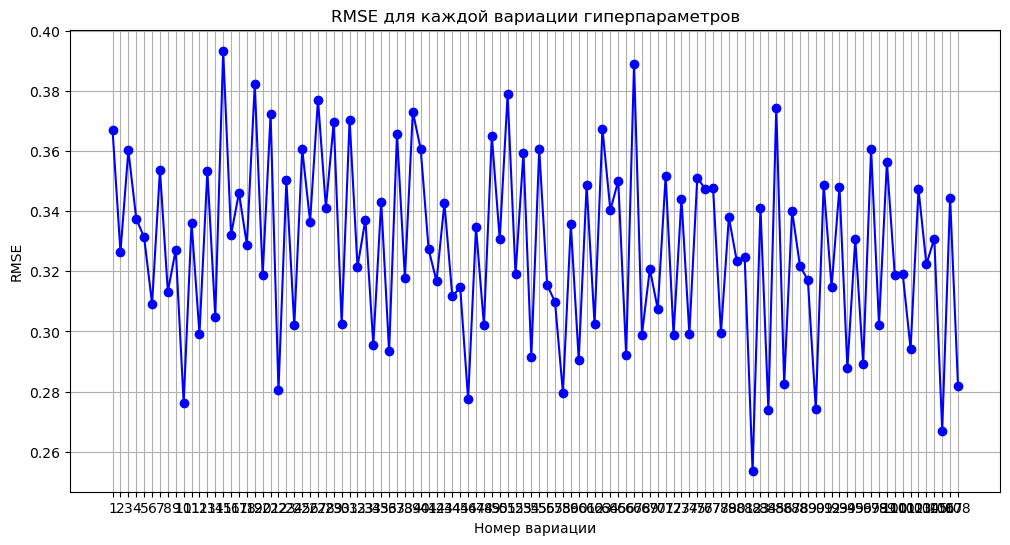

In [138]:
variation_numbers = range(1, len(results) + 1)

rmse_values = [result['val_rmse'] for result in results]

plt.figure(figsize=(12, 6))
plt.plot(variation_numbers, rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE для каждой вариации гиперпараметров')
plt.xlabel('Номер вариации')
plt.ylabel('RMSE')
plt.xticks(variation_numbers) 
plt.grid(True)
plt.show()

In [140]:
best_model = build_cnn_model(
    input_shape=(train_x.shape[1], 1),
    filters=128,
    units=64,
    kernel_size=2,
)
best_model.fit(train_x, train_y, batch_size=16, epochs=100, verbose=0)

best_clean_std_preds = best_model.predict(x_test_cnn)

best_test_rmse, best_test_r2 = evaluate_model_quality(y_test_res, best_clean_std_preds)
print(f"RMSE: {best_test_rmse}, R²: {best_test_r2}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
RMSE: 0.37504108542498343, R²: 0.8520782688530688


In [ ]:
# TODO: Сделать вывод, возможно немного оптимизировать Grid-search